# Supplementary Figure 6: Optimal thresholds

The optimal threshold when all cells above a given population density are considered, as determined by the Heidke skill score. Every threshold possible given the data was attempted though only the largest nine are shown here.

## Package imports

In [1]:
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

suppressPackageStartupMessages({
  library(tidyverse)
  library(latex2exp, lib.loc = additional_package_lib)
  library(scico)
  library(patchwork)
})

## Utility functions

In [2]:
hss <- function(pred, true){
  # Calculate the Heidke skill score
  #
  # Inputs:
  #  pred  vector
  #        binary predictions
  #  true  vector
  #        binary truth
  # 
  # Outputs:
  #  _     float
  #        heidke skill score
    
  # calculate elements of contingency table
  hits <- sum(pred & true)
  correct_negative <- sum(!pred & !true)
  misses <- sum(!pred & true)
  false_alarms <- sum(pred & !true)
    
  # number of predictions
  total <- length(true)
  
  # number of expected correct predictionrs 
  expected_correct <- (1 / total) * ((hits + misses) * (hits + false_alarms) + 
                                     (correct_negative + misses) * (correct_negative + false_alarms))
  
  # heidke skill score
  ((hits + correct_negative) - expected_correct) / (total - expected_correct)
}

test_thresh <- function(x, true){
  # Function to test every threshold on predictors x compared with 
  # truth true
  #
  # Inputs:
  #  x     vector
  #        the continous predictor
  #  true  vector
  #        the binary true and false occurrences 
  # 
  # Outputs:
  #  _     tibble
  #        two columns, first being the threshold value (ordered) and
  #        the second being the resulting heidke skill score
    
  # sort x to get unique threshold
  unique_x <- sort(unique(x))
  # calculate number of thresholds
  num_thresh <- length(unique_x)
  # pre-allocate for results
  res <- rep(0, num_thresh)

  # loop over all thresholds
  for (i in 1:num_thresh) {
    # predictions binary based on threshold
    pred <- x > unique_x[i]
    # calculate heidke skill score
    res[i] <- hss(pred, true)
  }
  
  # package into tibble
  tibble(thresh = unique_x, res = res)
}

hss_analysis <- function(pop_threshold){
  # Plot (MESH) thresholds against their heidke skill score
  #
  # Inputs:
  #  pop_threshold  float
  #                 threshold indicating minimum population density
  #                 used to filter data
  # 
  # Outputs:
  #  _              ggplot object
  #                 plot of threshold gainst heidke skill score
    
  # getting the data by filtering
  most_pop_cell <- clean_data %>%
    filter(pop_dens >= pop_threshold)

  # getting results for each threshold
  res <- test_thresh(most_pop_cell$mesh, most_pop_cell$report)
    
  # finding optimum threshold for annotation
  opt_thresh <- res %>%
    filter(res == max(res)) %>%
    pull(thresh)
    
  # plot colour
  plot_colour <- scico(1, begin = 0.2, end = 0.8, palette = "batlow")
    
  # plotting
  res %>%
    ggplot(aes(x = thresh, y = res)) + 
    geom_point(color = plot_colour) +
    # labelling
    xlab("MESH threshold [mm]") +
    ylab("Heidke skill score") +
    ggtitle(TeX(paste0("Population density$\\geq$", round(pop_threshold), " people km$^{-2}$"))) + 
    # annotate with optimal
    annotate("text", x = 90, y = 0.75, label = paste0("Optimal threshold\nMESH = ", round(opt_thresh), " mm"), 
             color = plot_colour) +
    # consistent limits for all plots for pretty grouped plot later
    xlim(0, 105) +
    ylim(0, 0.85)
}

## Reading data

In [3]:
clean_data <- read_csv(paste0("/g/data/w42/ig1052/bayesian_paper_data/modelling_data/",
                              "filtered_allpredictors_noedges_popdens_ssa_variable_diameter_",
                              "comment_radar_66_variable_mesh_t_x_y_binned_t_2010-01-01_",
                              "2016-04-24_6_x_151.75_153.50_0.25_y_-29.00_-26.50_0.25.csv"),
                      col_types = "nnTnnnnnnncnnfffff") # letting report be numeric for comparison

## Plotting

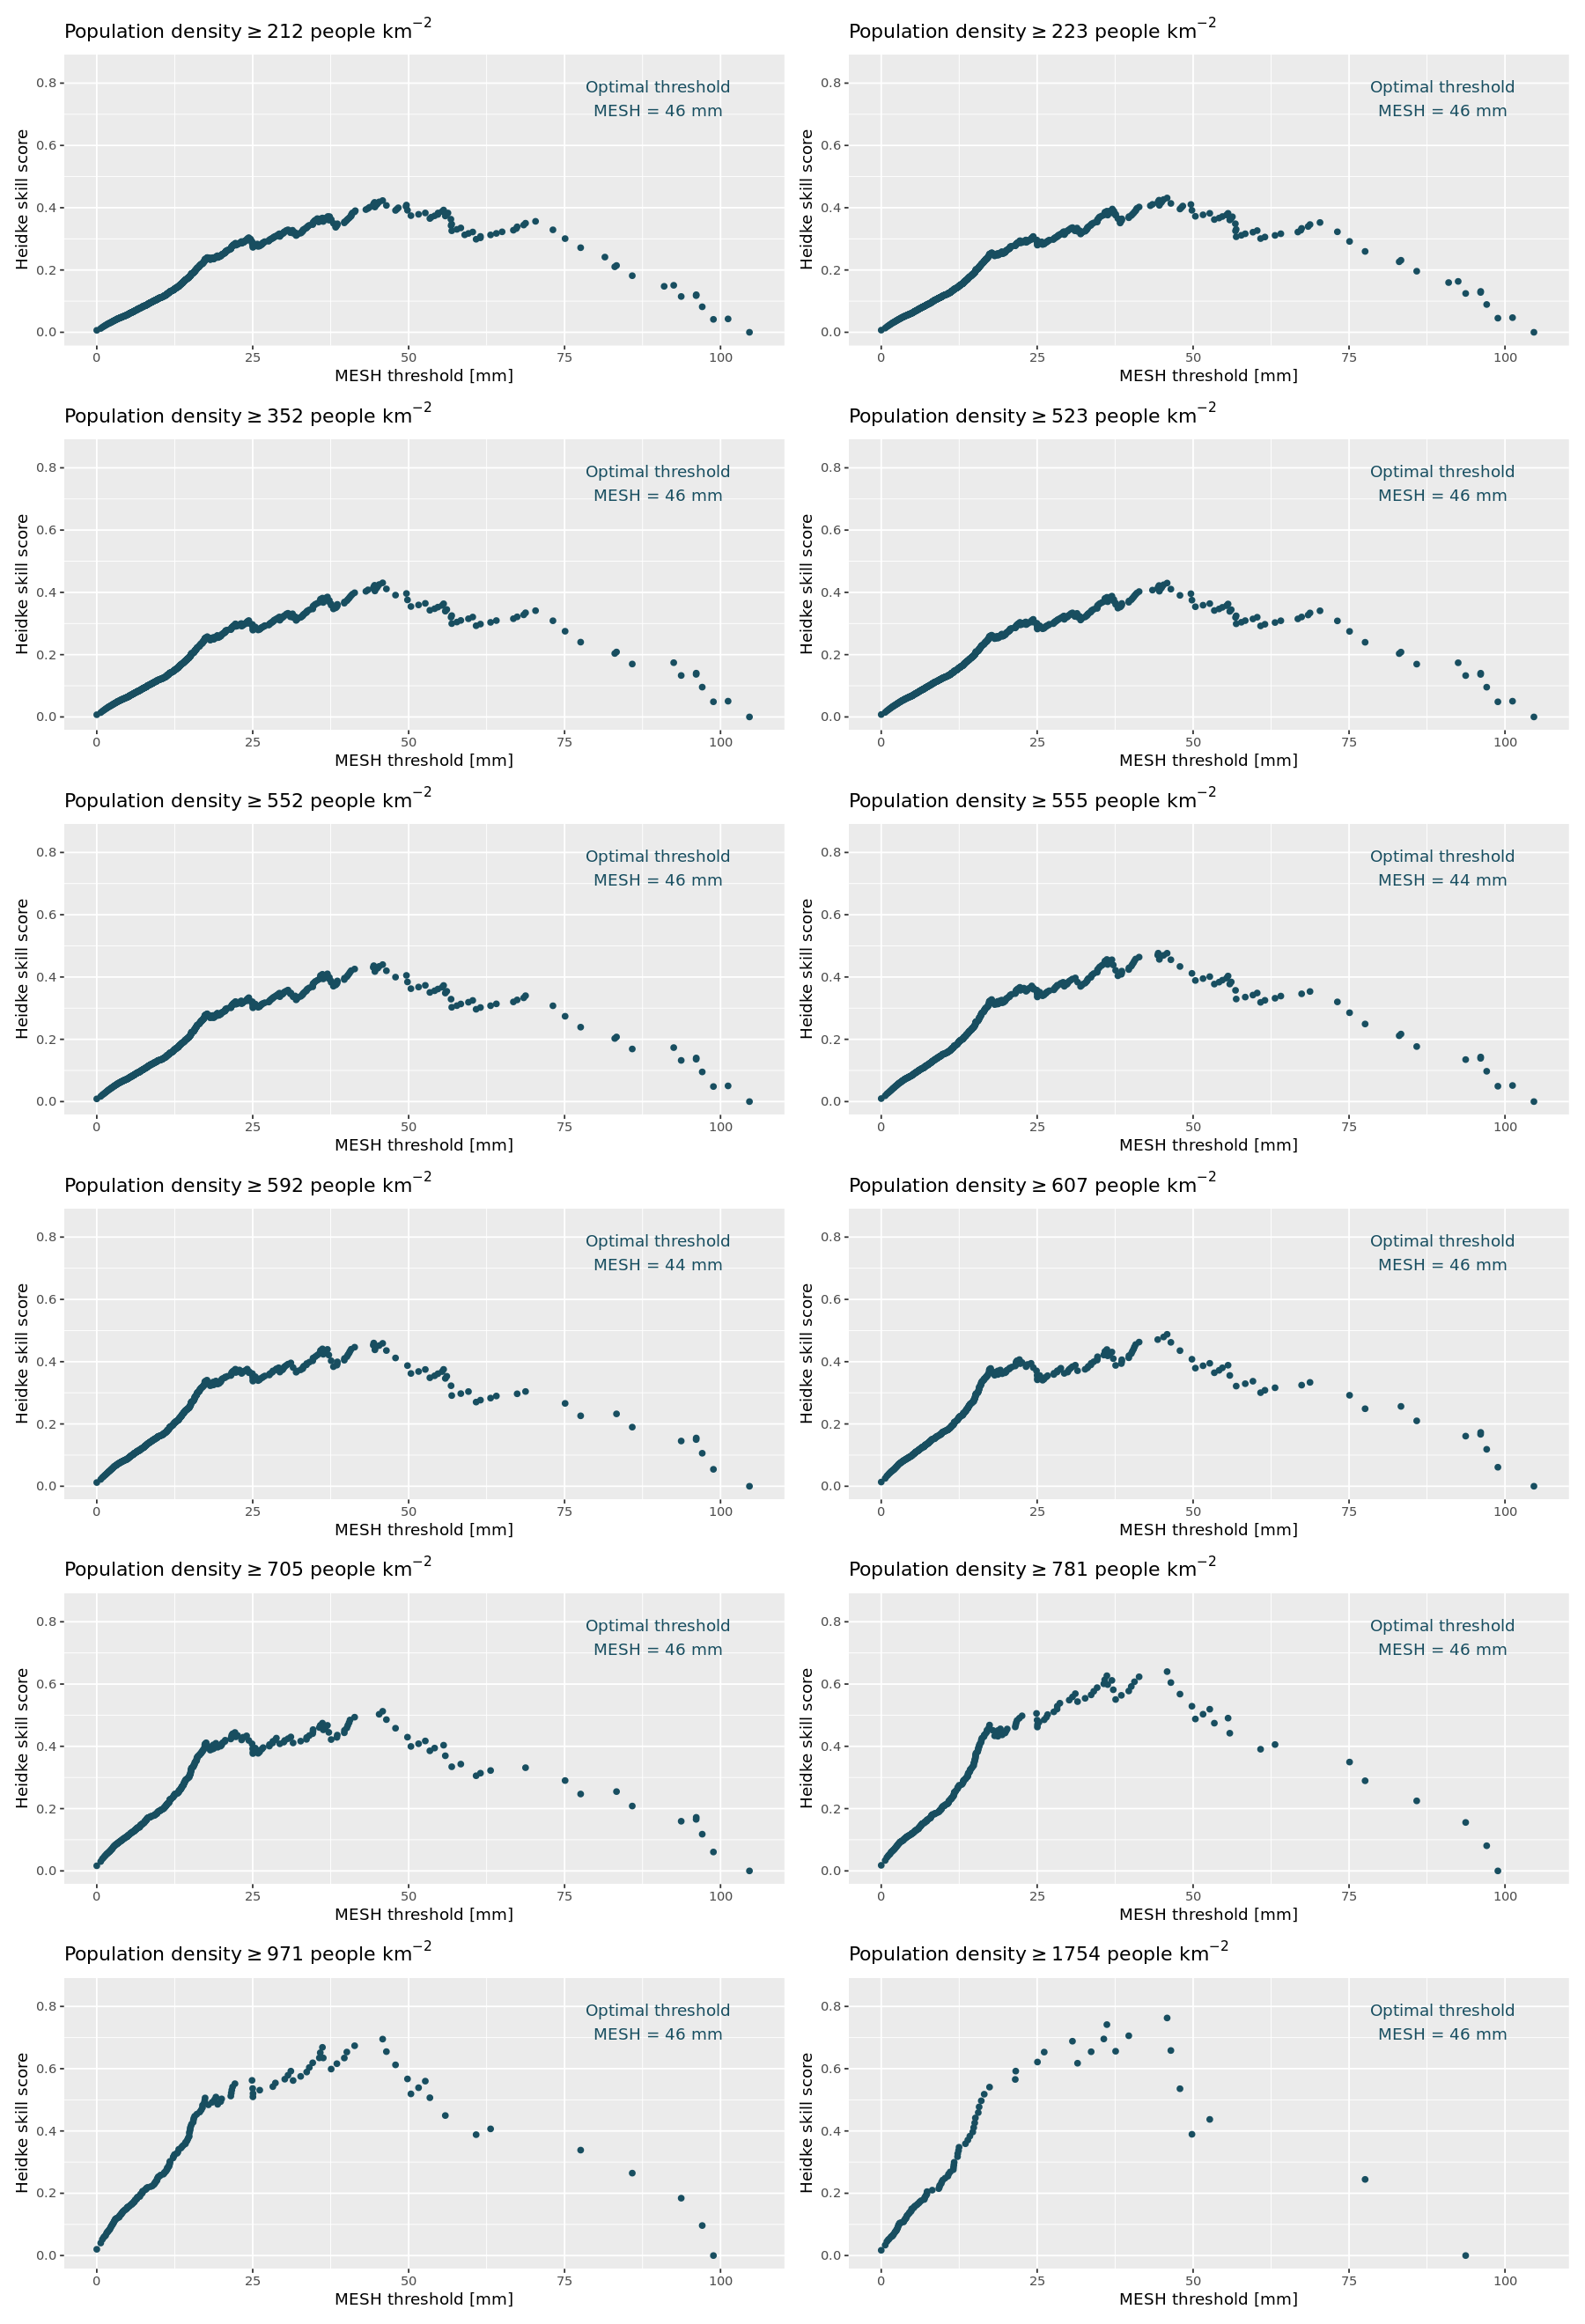

In [4]:
# plot size
options(repr.plot.width = 15, repr.plot.height = 22)

# get 12 highest population densities
tail(sort(unique(clean_data$pop_dens)), 12) %>%
  # create plot for each
  map(hss_analysis) %>%
  # wrap to grid
  wrap_plots(nrow = 6)